In [66]:
import os
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk

from tqdm import trange
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

plt.rcParams['figure.figsize'] = (17,7)

nltk.download("all-nltk")

[nltk_data] Downloading collection 'all-nltk'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /home/akeresh/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/akeresh/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /home/akeresh/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /home/akeresh/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /home/akeresh/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to
[nltk_

True

## Create datasets

In [3]:
def read_txt(path_to_txt):
    with open(path_to_txt, "r") as fin:
        fout = fin.readlines()
    return fout[0]

def create_df(path_to_folder: str, pattern: str = '**/*.txt'):
    labels = []
    texts = []
    for path in glob(os.path.join(path_to_folder, pattern)):
        label = os.path.dirname(path).split("/")[-1]
        text = read_txt(path)
        labels.append(label)
        texts.append(text)
    
    df = pd.DataFrame({"text": texts, "label": labels})
    return df

In [4]:
train = create_df("data/train/")

In [5]:
val = create_df("data/validat/")

In [6]:
test = pd.DataFrame({"text": [read_txt(i) for i in glob("data/test/*")]})

In [7]:
train.to_csv("train.csv", index=False)
val.to_csv("val.csv", index=False)
test.to_csv("test.csv", index=False)

## EDA

### Basic statistics

In [8]:
train["length"] = train["text"].str.len()

[Text(0.5, 1.0, 'Text lenght')]

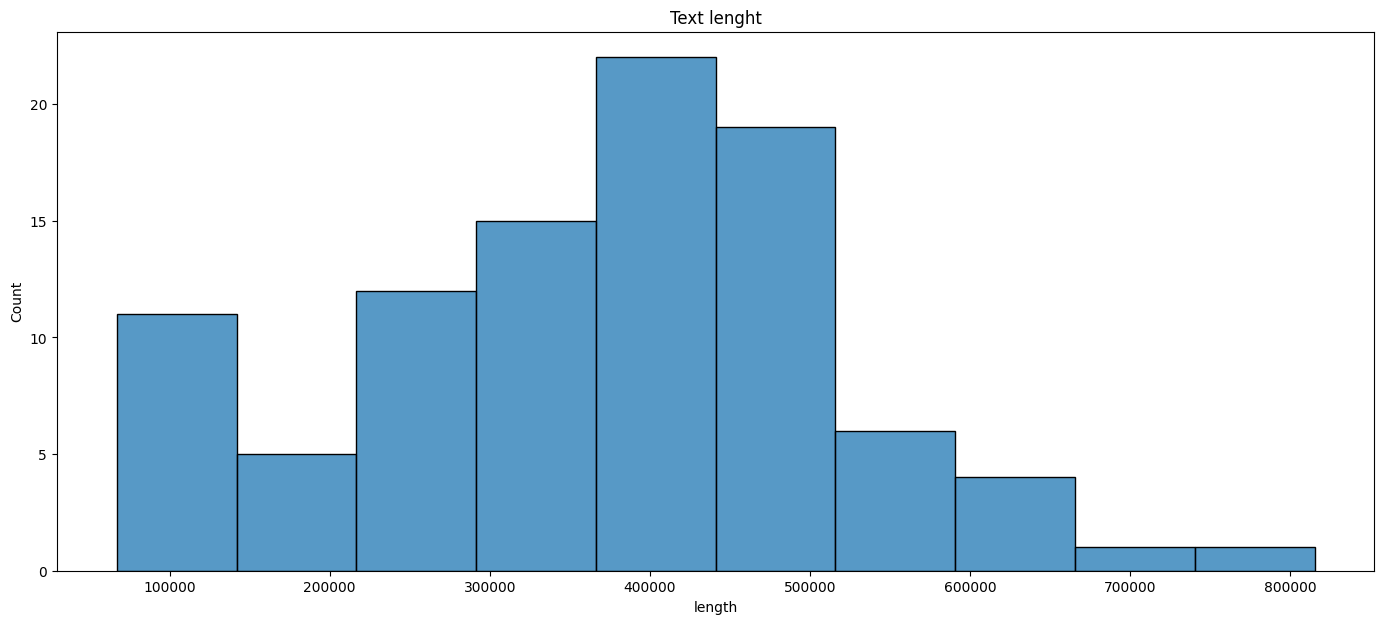

In [9]:
sns.histplot(train["length"]).set(title='Text lenght')

In [10]:
train["word_count"] = train["text"].str.split().str.len()

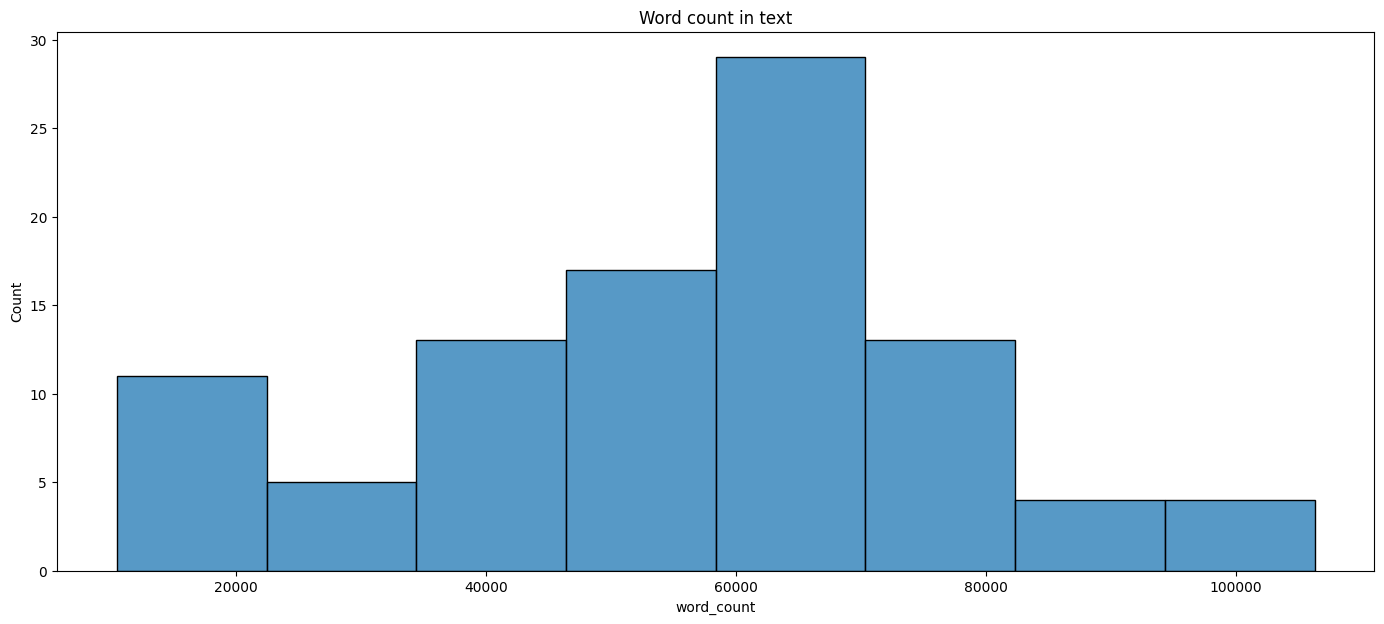

In [11]:
sns.histplot(train["word_count"]).set(title='Word count in text');

In [12]:
train['mean_word_length'] = train["text"].map(lambda rev: np.mean([len(word) for word in rev.split()]))

[Text(0.5, 1.0, 'Mean word lenght')]

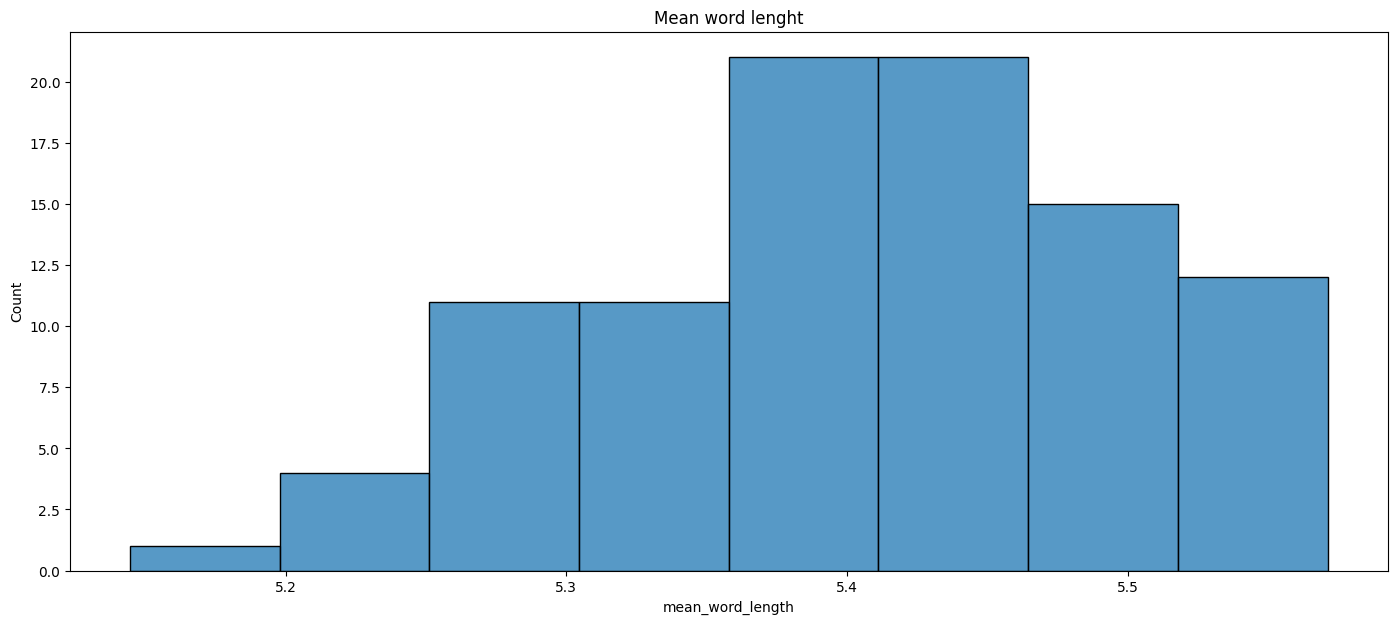

In [13]:
sns.histplot(train["mean_word_length"]).set(title='Mean word lenght')

In [14]:
train["sentence_count"] = train["text"].map(lambda rev: len(sent_tokenize(rev)))

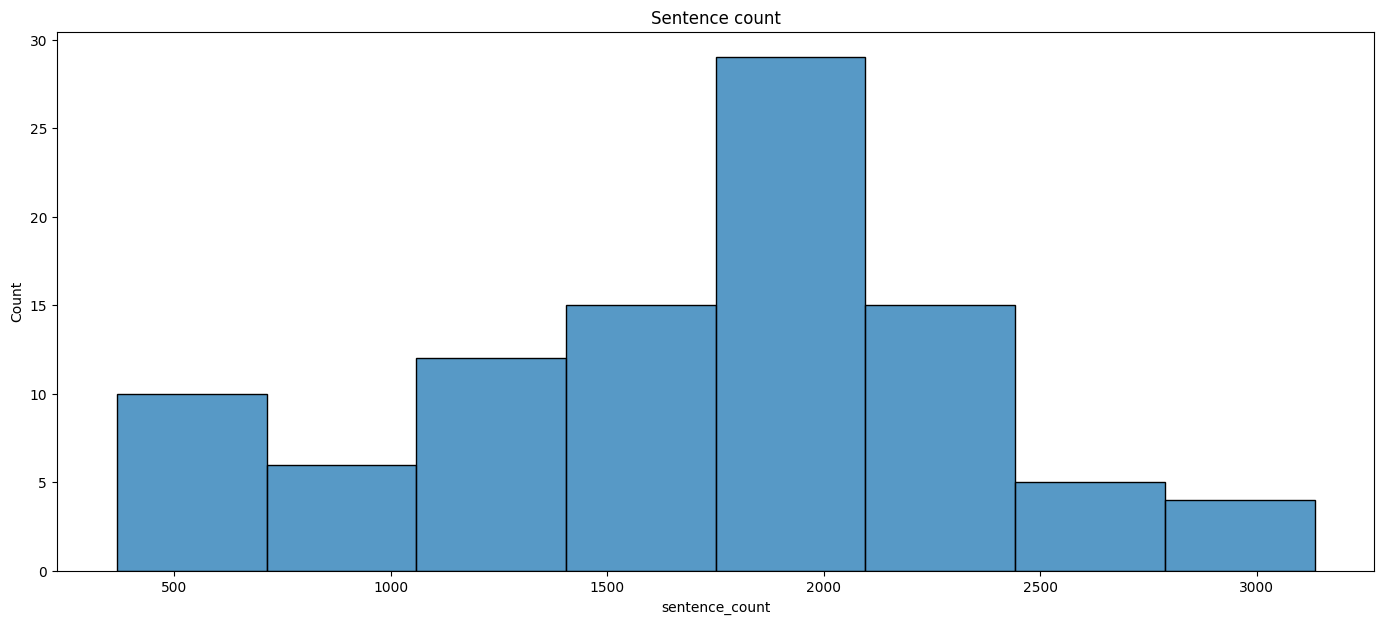

In [15]:
sns.histplot(train["sentence_count"]).set(title='Sentence count');

In [16]:
train["mean_sentence_length"] = train["text"].map(lambda rev: np.mean([len(sent) for sent in sent_tokenize(rev)]))

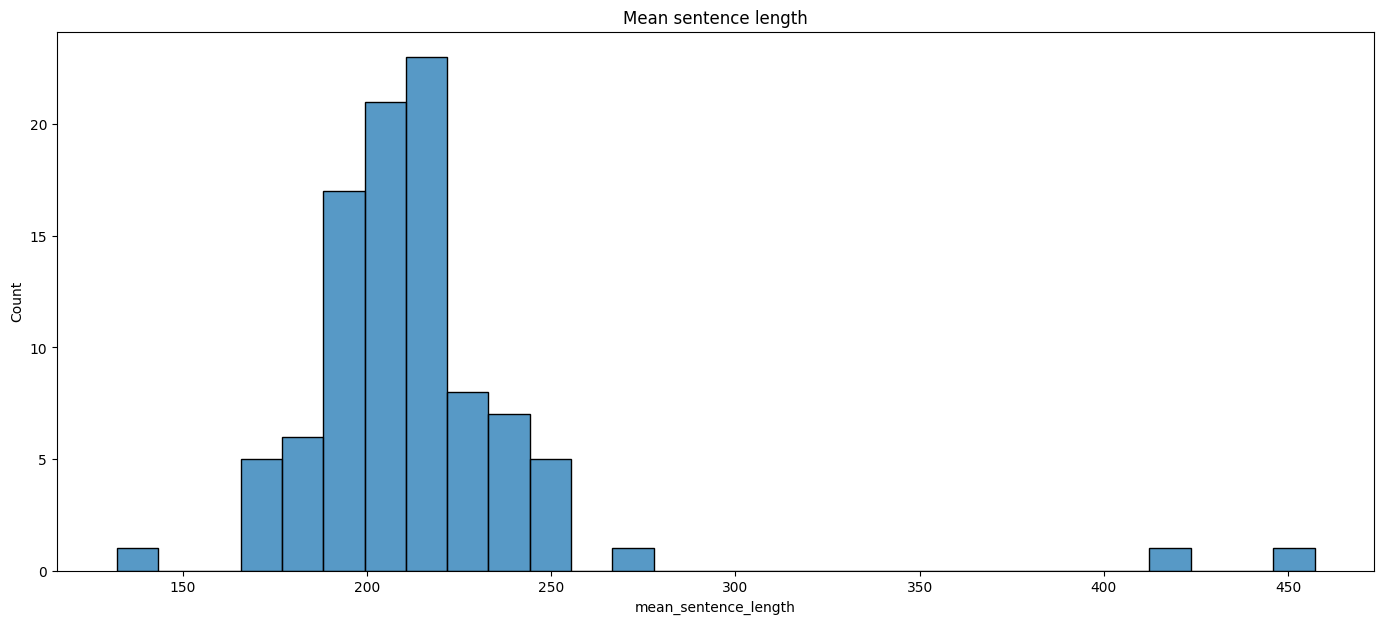

In [17]:
sns.histplot(train["mean_sentence_length"]).set(title='Mean sentence length');

In [18]:
train

,text,label,length,word_count,mean_word_length,sentence_count,mean_sentence_length
0,UNITED STATES SECURITIES AND EXCHANGE COMMISS...,pharma,474030,72965,5.496649,2232,211.411738
1,Table of Contents UNITED STATES SECURITIES AN...,pharma,354670,54824,5.469211,1802,195.820200
2,\t \t UNITED STATES SECURITIES AND EXCHANGE C...,pharma,252830,39102,5.465705,1309,192.145149
3,Use these links to rapidly review the documen...,pharma,405804,61985,5.546777,2012,200.692843
4,UNITED STATES SECURITIES AND EXCHANGE COMMISS...,pharma,107260,16682,5.429565,625,170.614400
...,...,...,...,...,...,...,...
91,Use these links to rapidly review the documen...,banks,555462,86062,5.454184,2292,241.347731
92,Table of Contents UNITED STATES SECURITIES AN...,banks,467334,73362,5.370219,2325,200.003441
93,Table of Contents UNITED STATES SECURITIES AN...,banks,430698,67629,5.368511,1715,250.135277
94,UNITED STATES SECURITIES AND EXCHANGE COMMISS...,banks,399561,62149,5.429050,1886,210.855779


In [19]:
def visualize(col):
    
    print()
    plt.subplot(1,2,1)
    sns.boxplot(y=train[col], hue=train['label'])
    plt.ylabel(col, labelpad=12.5)
    
    plt.subplot(1,2,2)
    sns.kdeplot(data=train, x=col, hue=train['label'])
    plt.legend(train['label'].unique())
    plt.xlabel('')
    plt.ylabel('')
    
    plt.show()

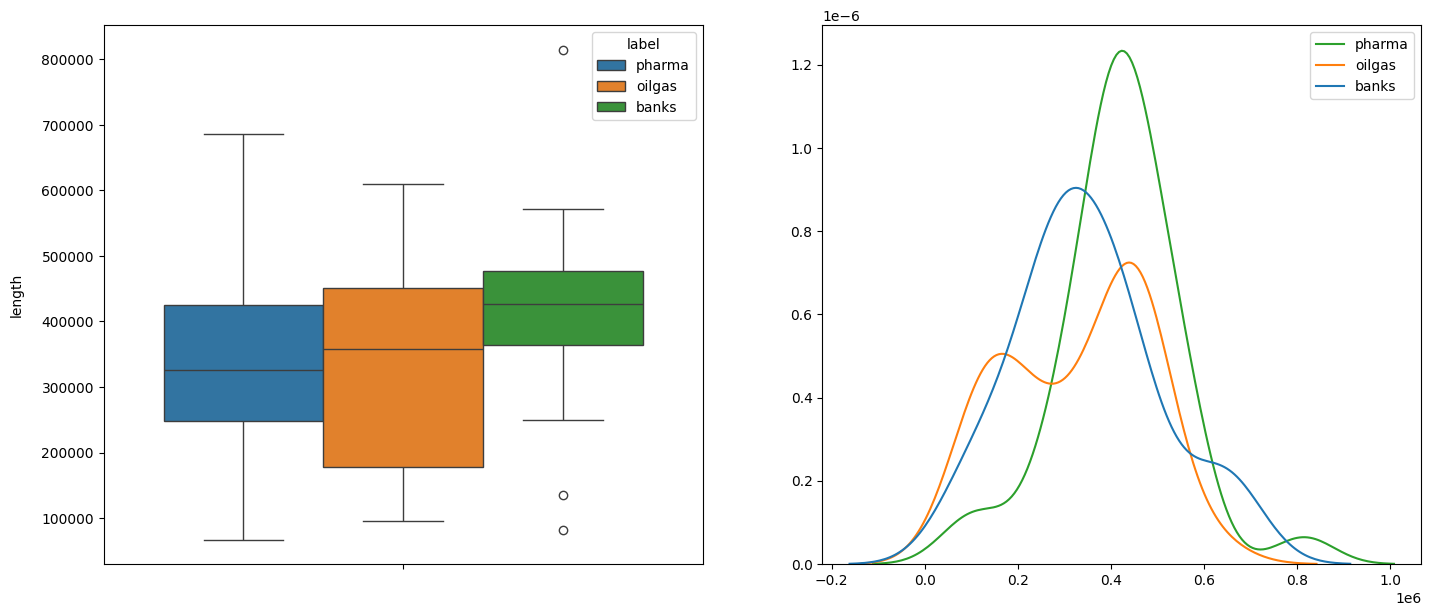

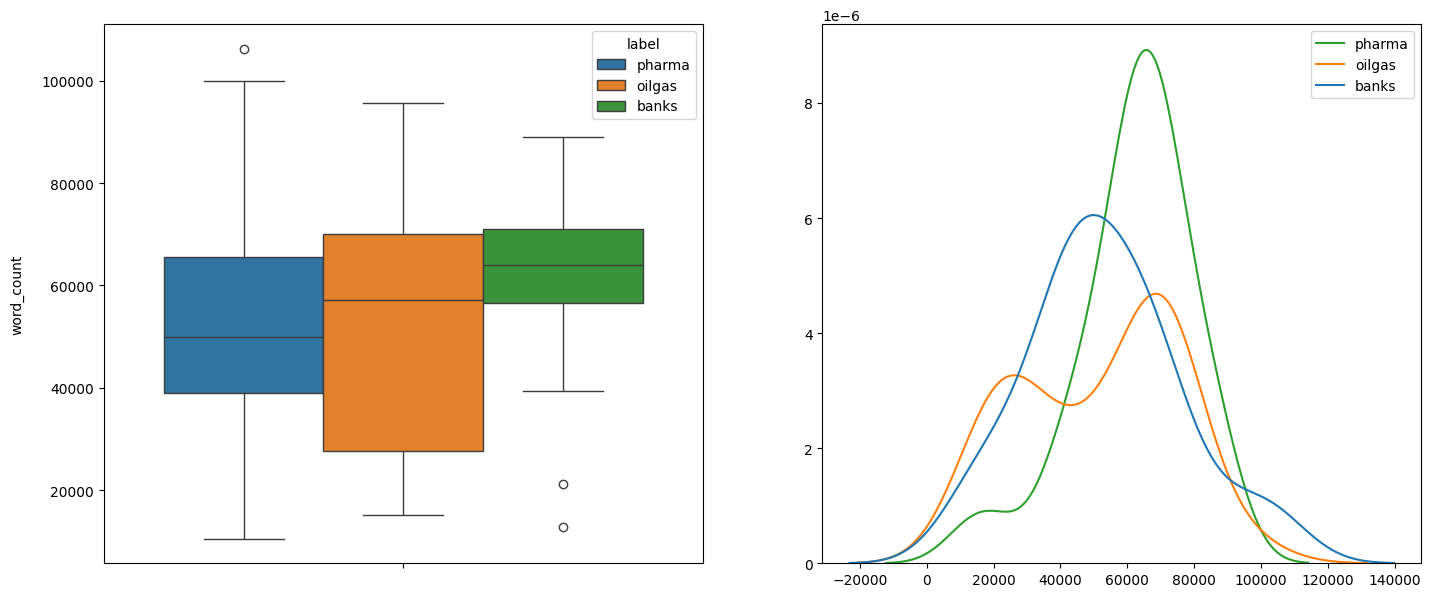

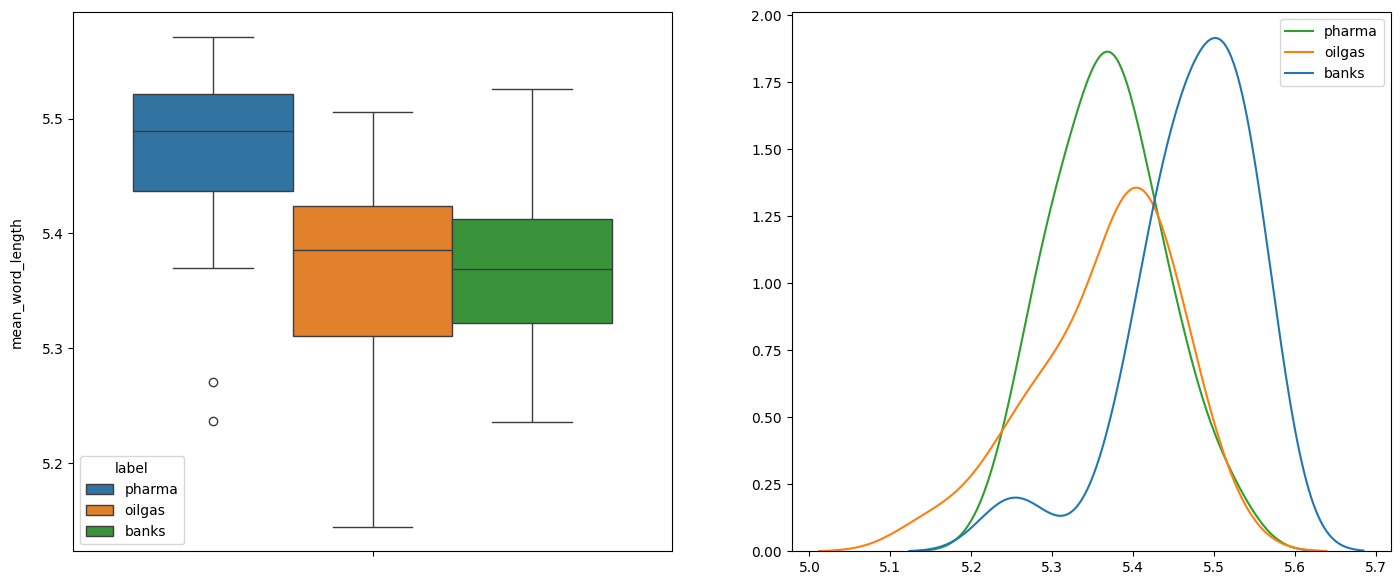

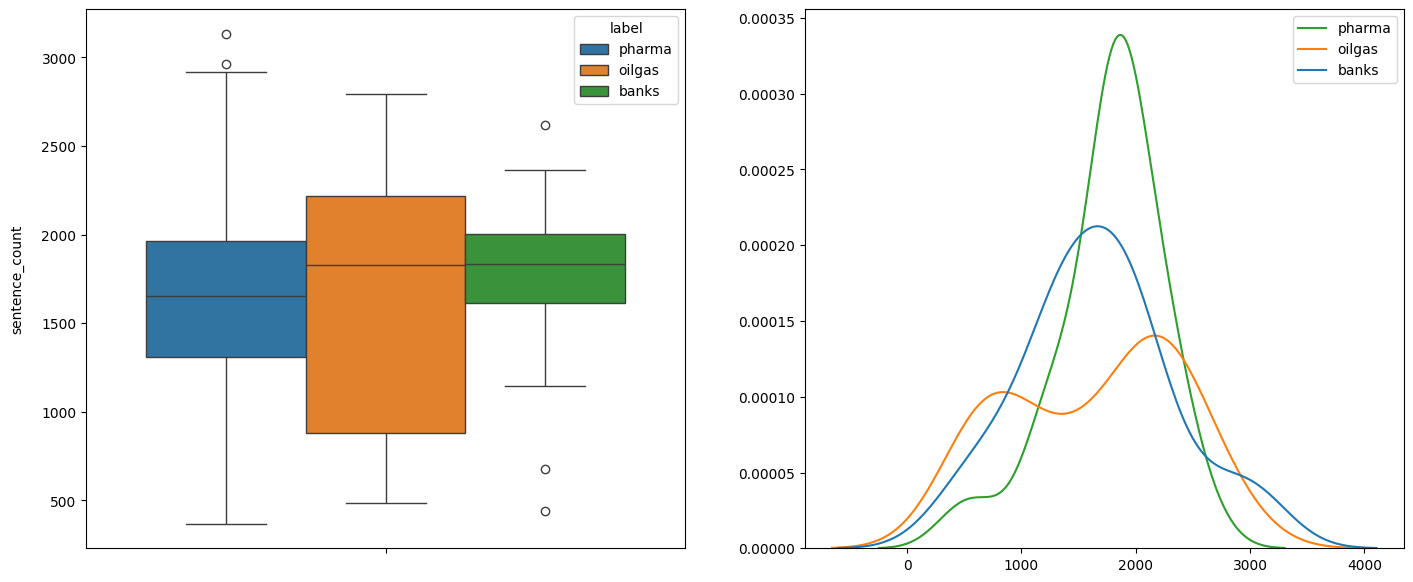

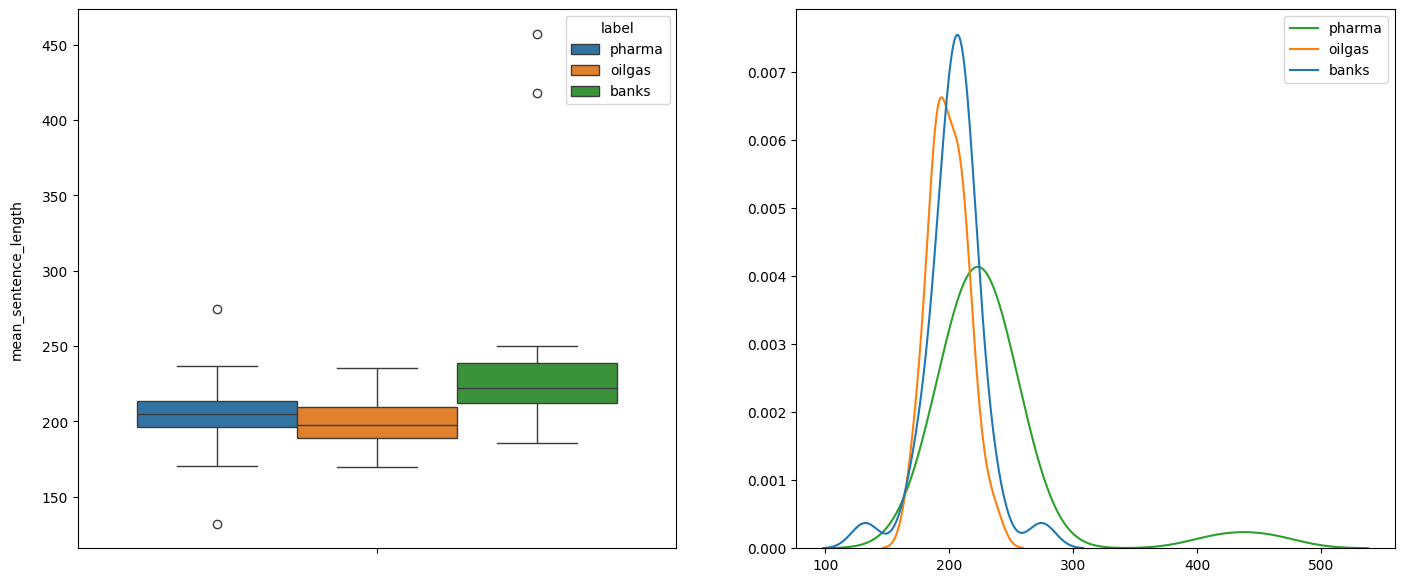

In [20]:
features = train.columns.tolist()[2:]
for feature in features:
    visualize(feature)

### Stopword Analysis

In [56]:
stop = set(stopwords.words('english'))

In [57]:
corpus=[]
texts = train["text"].str.split()
texts = texts.values.tolist()
corpus = [word for i in texts for word in i]

stopwords_dict = defaultdict(int)
for word in corpus:
    if word in stop:
        stopwords_dict[word]+=1

In [58]:
top_10_stopwords = sorted(stopwords_dict.items(), key=lambda x: x[1], reverse=True)[:10]

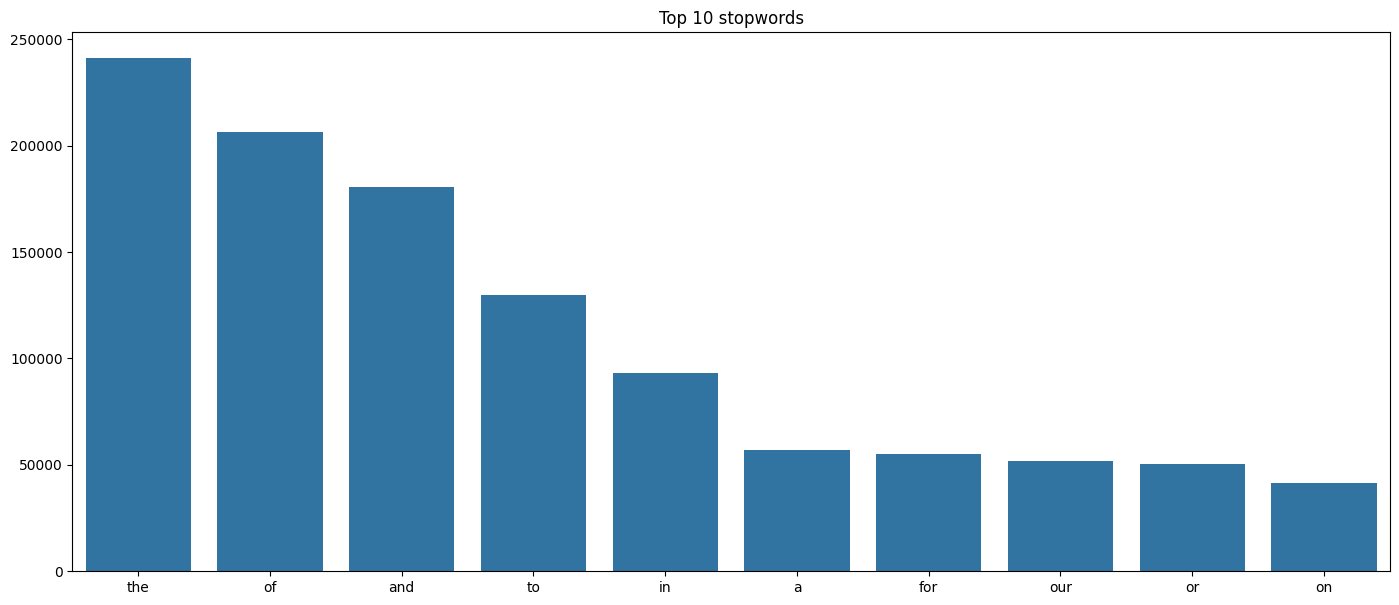

In [59]:
sns.barplot(dict(top_10_stopwords)).set(title='Top 10 stopwords');

### Frequently Occuring Words

In [85]:
def clean(review):
    
    review = review.lower()  # to lowercase
    review = re.sub('[^a-zA-Z -]+', '', review)  # delete punctuation 
    review = " ".join([word for word in review.split() if word not in stop])  # remove stopwords
    
    return review

In [86]:
train["clean_text"] = train["text"].map(clean)

In [87]:
texts = train["clean_text"].str.split().values.tolist()
corpus = [word for words in texts for word in words]

In [88]:
Counter(corpus).most_common(10)

[('company', 28004),
 ('december', 27474),
 ('financial', 23490),
 ('may', 20528),
 ('million', 18597),
 ('stock', 17800),
 ('-', 17281),
 ('loans', 17264),
 ('net', 15600),
 ('interest', 15388)]